In [10]:
import tensorflow as tf

In [11]:
tf.__version__

'2.2.0'

In [12]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import handshape_datasets as hd
from IPython import display
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

### Clean GPU

In [320]:
#Check GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()

1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


True

## Load dataset with handshape_datasets

In [5]:
data = hd.load('lsa16')

good_min = 40
good_classes = []
n_unique = len(np.unique(data[1]['y']))
for i in range(n_unique):
    images = data[0][np.equal(i, data[1]['y'])]
    if len(images) >= good_min:
        good_classes = good_classes + [i]
        
x = data[0][np.in1d(data[1]['y'], good_classes)]
img_shape = x[0].shape

y = data[1]['y'][np.in1d(data[1]['y'], good_classes)]
y_dict = dict(zip(np.unique(y), range(len(np.unique(y)))))
y = np.vectorize(y_dict.get)(y)

#x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, stratify=y)

#classes = np.unique(y_train)
#n_classes = len(classes)
#train_size = x_train.shape[0]
#test_size = x_test.shape[0]

train_images = x

train_images.shape

INFO:Loading lsa16...
INFO:Loading default version: color


(800, 32, 32, 3)

## Load dataaset locally

In [110]:
def normalize_images(images):
    return (images - 127.5) / 127.5

In [321]:
#Directorio de imagenes
train_folderpath = '../../../../datasets/lsa16_64x64_rotated/full/class_15'
    
train_images=[]
for file in os.listdir(os.path.join(train_folderpath)):
    image_path= os.path.join(train_folderpath, file)
    image= np.array(Image.open(image_path))
    image = image.astype('float32')
    image = normalize_images(image) 
    train_images.append(image)

train_images = np.array(train_images)
train_images.shape
        

(800, 64, 64, 3)

## Hyperparameters

In [322]:
# training
g_lr = 1e-4
d_lr = 1e-4
epochs = 1000
#max_patience = 200
#min_loss = 25
#min_loss_acc = 0
batch_size = 128
noise_dim = 100
num_examples_to_generate = 16

# log
log_freq = 1
dataset_directory = "class_15/"
models_directory = 'results/generators_weights/lsa16_64x64_rotated/' + dataset_directory
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
save_image_directory = "../../../../data_gen/Basic-GAN/lsa16_64x64_rotated/" + dataset_directory

# shapes
img_n , height, weight, chanels = train_images.shape

print(" number of images: {}\n height: {}\n weight: {}\n chanels: {}".format(img_n , height, weight, chanels))
save_image_directory

 number of images: 800
 height: 64
 weight: 64
 chanels: 3


'../../../../data_gen/Basic-GAN/lsa16_64x64_rotated/class_15/'

## Normalization

Debemos escalar los valores de los píxeles desde el rango de enteros sin signo en [0,255] al rango normalizado de [-1,1].

El modelo del generador generará imágenes con valores de píxeles en el rango [-1,1] ya que utilizará la función de activación tanh.

También es una buena práctica que las imágenes reales se escalen al mismo rango

In [9]:
train_images = train_images.reshape(img_n, height, weight, chanels).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_images

array([[[[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        ...,

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
        

## Create batch generator

In [323]:
BUFFER_SIZE = img_n
BATCH_SIZE = 128

In [324]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [325]:
train_dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

## Viewing some images

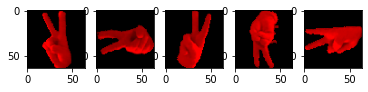

In [326]:
for image_batch in train_dataset:
    f, axarr = plt.subplots(1,5) 
    for i in range(0,5):
        axarr[i].imshow((image_batch[i]+1)/2.0) #scale pixel values from [-1,1] to [0,1]
    break

## Defining generator model

In [327]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(int(height/4)*int(weight/4)*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((int(height/4), int(weight/4), 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 65536)             6553600   
_________________________________________________________________
batch_normalization_42 (Batc (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 65536)             0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 16, 16, 128)     

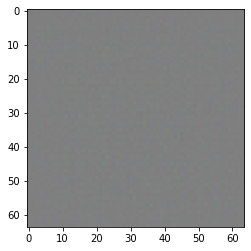

In [328]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0]+1)/2.0)

## Defining  discriminator model

In [329]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[height, weight, chanels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [330]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00302843]], shape=(1, 1), dtype=float32)


## Defining loss and optimizers

In [331]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [332]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [333]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [334]:
generator_optimizer = tf.keras.optimizers.Adam(g_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(d_lr)

## Function to generate and save images

In [335]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :] +1)/2.0) #scale pixel values from [-1,1] to [0,1]
        plt.axis('off')
    
    if not os.path.exists(save_image_directory):
        os.makedirs(save_image_directory)
            
    plt.savefig(save_image_directory + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Define the training cycle

In [336]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [337]:
def train(dataset, epochs):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        
        if epoch % 10 == 0:
            generate_and_save_images(generator,
                                     epoch,
                                     seed)

        # Save the model every 10 epochs
        '''if epoch % 10 == 0:
            if not os.path.exists(models_directory):
                os.makedirs(models_directory)
            # serialize weights to HDF5
            generator.save_weights(models_directory + "generator-iteration-{}-date-{}.h5".format(epoch, date))
        '''
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

## Training

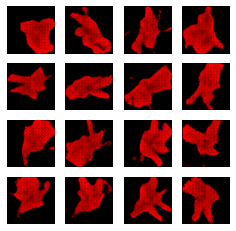

In [338]:
train(train_dataset, 2200)

## Create GIF

In [38]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(save_image_directory+'image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [339]:
seed = tf.random.normal([700, noise_dim])
generated_images = generator(seed, training=False)

In [340]:
import matplotlib
path = '/home/willys/tesis/Data-augmentation-using-GANs/datasets/lsa16_64x64_rotated/train_augmentation/'
image_class = 'class_15/'
i = 0

for image in generated_images:
    proto_tensor = tf.make_tensor_proto(image)
    ndarray = tf.make_ndarray(proto_tensor)
    matplotlib.image.imsave(path + image_class + 'image_generated_{}.png'.format(i), (ndarray+ 1) / 2.0)
    i+=1

In [110]:
#Generator sin data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=normalize_images)

#Directorio de imagenes
train_folderpath = '/home/willys/tesis/Data-augmentation-using-GANs/prueba'
#train_folderpath='/home/willys/tesis/Data-augmentation-using-GANs/datasets/lsa16_64x64_rotated/full'

In [111]:


batch_size = 128

train_generator = train_datagen.flow_from_directory(
    train_folderpath, # directorio de donde cargar las imagenes (train)
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='sparse')

img_n = train_generator.samples



Found 266 images belonging to 2 classes.
